# Análisis y Limpieza de Dataset Fintech

Este análisis tiene como objetivo limpiar, transformar y explorar un dataset de clientes financieros con el fin de identificar patrones relevantes en el comportamiento crediticio.

In [3]:
import pandas as pd
import numpy as np

## 1. Carga del Dataset

Se carga el dataset generado previamente con valores nulos y posibles valores atípicos para su posterior análisis.

In [4]:
df = pd.read_csv("dataset_fintech_sucio.csv")
df.head()

,cliente_id,edad,ingreso_mensual,monto_credito,score_crediticio,tipo_cliente,tiene_mora
0,1,56,1.330539e+06,1.828952e+06,NaN,Recurrente,0
1,2,69,1.058116e+06,4.264370e+06,357.0,Premium,0
2,3,46,4.201575e+05,2.000000e+07,558.0,Premium,0
3,4,32,6.789415e+05,6.158858e+06,641.0,Nuevo,0
4,5,60,1.116728e+06,3.591981e+06,429.0,Premium,1


## 2. Exploración Inicial del Dataset

Se analiza la estructura del dataset, tipos de datos y presencia de valores nulos.

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cliente_id        500 non-null    int64  
 1   edad              500 non-null    int64  
 2   ingreso_mensual   480 non-null    float64
 3   monto_credito     500 non-null    float64
 4   score_crediticio  485 non-null    float64
 5   tipo_cliente      500 non-null    str    
 6   tiene_mora        500 non-null    int64  
dtypes: float64(3), int64(3), str(1)
memory usage: 27.5 KB


## 3. Tratamiento de Valores Nulos

Se identifican valores faltantes en las variables `ingreso_mensual` y `score_crediticio`.  
Dado que el porcentaje es bajo, se decide imputar utilizando la mediana para evitar distorsión por valores extremos.

In [6]:
df.isnull().sum()

cliente_id           0
edad                 0
ingreso_mensual     20
monto_credito        0
score_crediticio    15
tipo_cliente         0
tiene_mora           0
dtype: int64

In [7]:
# Imputar ingreso_mensual con mediana
df["ingreso_mensual"] = df["ingreso_mensual"].fillna(df["ingreso_mensual"].median())

# Imputar score_crediticio con mediana
df["score_crediticio"] = df["score_crediticio"].fillna(df["score_crediticio"].median())

In [8]:
df.isnull().sum()

cliente_id          0
edad                0
ingreso_mensual     0
monto_credito       0
score_crediticio    0
tipo_cliente        0
tiene_mora          0
dtype: int64

In [9]:
df.describe()

,cliente_id,edad,ingreso_mensual,monto_credito,score_crediticio,tiene_mora
count,500.000000,500.000000,5.000000e+02,5.000000e+02,500.000000,500.000000
mean,250.500000,44.220000,1.279159e+06,3.321858e+06,579.410000,0.228000
std,144.481833,15.036082,4.907531e+06,2.053354e+06,156.802065,0.419963
min,1.000000,18.000000,-1.031684e+04,-4.755065e+05,306.000000,0.000000
25%,125.750000,32.000000,6.247800e+05,2.333677e+06,446.500000,0.000000
50%,250.500000,45.000000,7.928975e+05,3.156644e+06,569.000000,0.000000
75%,375.250000,57.000000,9.528298e+05,3.953365e+06,713.500000,0.000000
max,500.000000,69.000000,5.000000e+07,2.000000e+07,849.000000,1.000000


In [10]:
Q1 = df["monto_credito"].quantile(0.25)
Q3 = df["monto_credito"].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

limite_superior

np.float64(6382896.057520328)

Los valores extremos fueron identificados mediante el método IQR. 
Se decidió mantenerlos en el dataset debido a que pueden representar 
comportamientos financieros reales y no errores de registro.

## 4. Detección y Tratamiento de Valores Atípicos

Se utiliza el método del rango intercuartílico (IQR) para identificar valores extremos en la variable `monto_credito`.  
Los valores que superan el límite superior estadístico son tratados mediante winsorización.

In [11]:
outliers = df[df["monto_credito"] > limite_superior]
outliers

,cliente_id,edad,ingreso_mensual,monto_credito,score_crediticio,tipo_cliente,tiene_mora
2,3,46,420157.508511,20000000.0,558.0,Premium,0
39,40,69,676749.766335,20000000.0,759.0,Premium,0
58,59,24,745579.699193,20000000.0,615.0,Nuevo,0
281,282,42,497245.950059,20000000.0,762.0,Premium,0
348,349,68,989247.154161,20000000.0,356.0,Recurrente,0


Se detectaron 5 valores atípicos en la variable "monto_credito" utilizando el método del rango intercuartílico (IQR).
Estos valores (20.000.000) superan el límite superior estadístico (~6.38 millones), por lo que se decide aplicar winsorización, reemplazándolos por el límite superior para evitar distorsión en los análisis posteriores sin eliminar registros.

In [12]:
df.loc[df["monto_credito"] > limite_superior, "monto_credito"] = limite_superior

In [13]:
df["monto_credito"].max()

np.float64(6382896.057520328)

Se eliminaron posibles registros duplicados para evitar sesgos en el análisis y garantizar la integridad del dataset.

In [17]:
df = df.drop_duplicates()

La variable `tipo_cliente` fue transformada a formato numérico para permitir análisis cuantitativos adicionales y posibles modelamientos futuros.

In [18]:
df["tipo_cliente_cod"] = df["tipo_cliente"].astype("category").cat.codes

## 5. Análisis de Relaciones entre Variables

Se analiza la correlación entre variables numéricas para identificar posibles relaciones relevantes para el comportamiento crediticio.

In [14]:
df.corr(numeric_only=True)

,cliente_id,edad,ingreso_mensual,monto_credito,score_crediticio,tiene_mora
cliente_id,1.000000,0.061964,-0.003924,-0.074349,-0.081487,0.042308
edad,0.061964,1.000000,0.092959,-0.031432,-0.123395,-0.002882
ingreso_mensual,-0.003924,0.092959,1.000000,0.013678,-0.071131,0.040627
monto_credito,-0.074349,-0.031432,0.013678,1.000000,-0.048057,-0.038742
score_crediticio,-0.081487,-0.123395,-0.071131,-0.048057,1.000000,-0.026681
tiene_mora,0.042308,-0.002882,0.040627,-0.038742,-0.026681,1.000000


### Interpretación de Correlaciones

Las correlaciones entre variables numéricas son bajas (cercanas a 0), lo que indica ausencia de relaciones lineales fuertes.

La relación más destacable es entre `edad` y `score_crediticio` (-0.12), aunque su magnitud sigue siendo débil.

En general, el comportamiento de mora (`tiene_mora`) no muestra una asociación lineal significativa con ingreso, monto de crédito o score crediticio.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

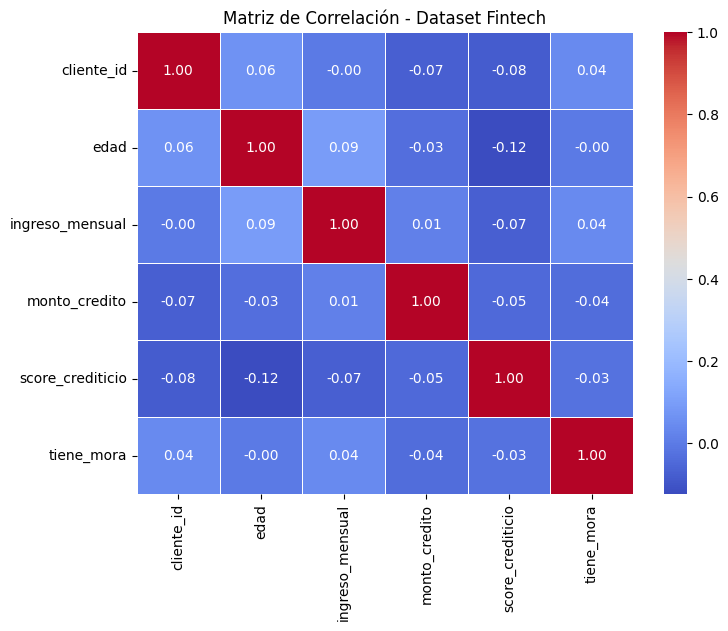

In [16]:
plt.figure(figsize=(8,6))

sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Matriz de Correlación - Dataset Fintech")
plt.show()

### Conclusiones del Análisis de Correlación

La matriz de correlación confirma que las relaciones lineales entre variables son débiles.
No se identifican asociaciones significativas entre el comportamiento de mora (tiene_mora) y variables financieras como ingreso mensual, monto de crédito o score crediticio.

La correlación más destacable es entre edad y score crediticio (-0.12), aunque su magnitud sigue siendo baja.

Estos resultados sugieren que el comportamiento crediticio podría depender de variables adicionales no incluidas en el dataset o de relaciones no lineales.

## 6. Análisis de Mora por Segmento

Se calculó la tasa promedio de mora por tipo de cliente para identificar posibles patrones de riesgo asociados a segmentos específicos.

In [19]:
df.groupby("tipo_cliente")["tiene_mora"].mean()

tipo_cliente
Nuevo         0.205714
Premium       0.273256
Recurrente    0.202614
Name: tiene_mora, dtype: float64

### Promedio de monto_credito por tipo_cliente

In [20]:
df.groupby("tipo_cliente")["monto_credito"].mean()

tipo_cliente
Nuevo         3.172725e+06
Premium       3.145726e+06
Recurrente    3.245436e+06
Name: monto_credito, dtype: float64

## 7. Exportación de Datos

El dataset procesado fue exportado en formato CSV y Excel para facilitar su visualización, análisis posterior y elaboración de reportes ejecutivos.

In [ ]:
df.to_csv("dataset_fintech_limpio.csv", index=False) # Guardar CSV sin índice

In [22]:
df.to_excel("dataset_fintech_limpio.xlsx", index=False) # Exportar a Excel

# Conclusión General

El análisis permitió estructurar y limpiar el dataset, garantizando su consistencia para análisis posteriores.

No se identificaron relaciones lineales fuertes entre variables financieras y el comportamiento de mora, lo que sugiere que podrían influir factores adicionales no considerados en el dataset actual.

El análisis segmentado por tipo de cliente aporta valor estratégico, permitiendo evaluar diferencias de riesgo entre perfiles.